One particularly interesting channel in `block2.res1.resadd_out` is _channel 55_. In this notebook, we will: 
1. Visualize channel 55 and demonstrate **that it positively activates on cheese and weakly negatively activates elsewhere**, 
2. Demonstrate how the agent can sometimes be retargeted using a simple synthetic activation patch, and
3. Show that this channel can weakly increase cheese-seeking (multiply by >1), decrease cheese-seeking (zero- or mean-ablate), strongly promote cheese-avoidance (multiply by < -1), and promote no-ops (multiply by << -1). 
4. Demonstrate that in `block2.res1.resadd_out` `cheese_channels=[7,8,42,44,55,77,82,88,99,113]` appear to encode cheese position in a similar manner. With the exception of channels `7, 44, 99`, the "cheese channels" mimic channel 55 in that they also individually ret arget the agent's behavior

Already downloaded https://nerdsniper.net/mats/model_rand_region_5.pth


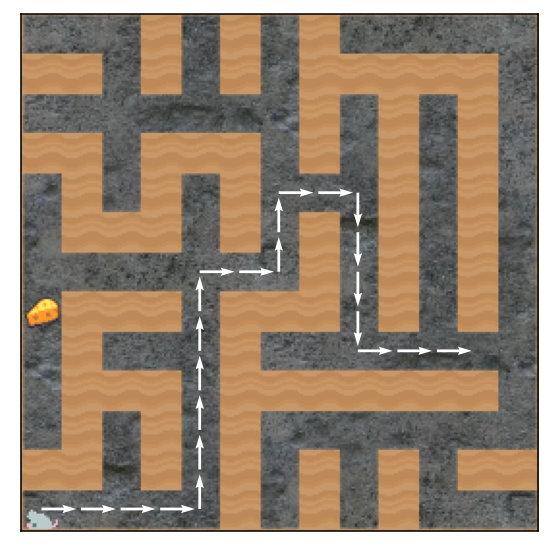

In [1]:
try:
    import procgen_tools
except ImportError or ModuleNotFoundError:
    get_ipython().run_line_magic(magic_name='pip', line='install -U git+https://github.com/ulissemini/procgen-tools')

from procgen_tools.utils import setup

setup() # create directory structure and download data 

from procgen_tools.imports import *
from procgen_tools import visualization, patch_utils, maze
import os


In [2]:
cheese_channels = [77, 113, 44, 88, 55, 42, 7, 8, 82, 99] 
effective_channels = [77, 113, 88, 55, 8, 82, 89]

SAVE_DIR = 'experiments'
AX_SIZE = 6

# Visualizing channel 55

Try clicking on the left-ward level editor below. Move the cheese around the maze by clicking on the yellow tile, and then clicking on the tile you want to contain the cheese. Watch the positive blue activations equivariantly translate along with the cheese!

In [3]:
# Show a maze editor side-by-side with the interactive plotter
SEED = 1
venv = maze.create_venv(num=1, start_level=SEED, num_levels=1) # This has to be a single maze, otherwise the vfield wont work

default_settings = {'channel_slider': 55, 'label_widget': 'block2.res1.resadd_out'}
custom_maze_plotter = visualization.ActivationsPlotter(labels, lambda activations, fig: visualization.plot_activations(activations[0], fig=fig), patch_utils.values_from_venv, hook, defaults=default_settings, venv=venv)

widget_box = visualization.custom_vfield(policy, venv=venv, callback=custom_maze_plotter.update_plotter) 
display(widget_box)
    
custom_maze_plotter.display() 

Box(children=(HBox(children=(GridspecLayout(children=(Button(layout=Layout(grid_area='widget001', height='0px'…

FigureWidget({
    'data': [{'colorscale': [[0.0, 'rgb(103,0,31)'], [0.1, 'rgb(178,24,43)'],
                             [0.2, 'rgb(214,96,77)'], [0.3, 'rgb(244,165,130)'],
                             [0.4, 'rgb(253,219,199)'], [0.5, 'rgb(247,247,247)'],
                             [0.6, 'rgb(209,229,240)'], [0.7, 'rgb(146,197,222)'],
                             [0.8, 'rgb(67,147,195)'], [0.9, 'rgb(33,102,172)'],
                             [1.0, 'rgb(5,48,97)']],
              'type': 'heatmap',
              'uid': 'f0e9c32c-bd4f-4f27-8b79-f0ac7a9cb541',
              'z': array([[ 0.02657259, -0.02839199, -0.07337215, ..., -0.0436724 , -0.02377843,
                           -0.01424355],
                          [-0.00080799, -0.16589718, -0.19343732, ..., -0.17971098, -0.13789411,
                           -0.08407791],
                          [-0.0606579 , -0.25140518, -0.23488963, ..., -0.2229431 , -0.201258  ,
                           -0.19534563],
                  

# Intervening on 55
It turns out that channel 55 lets us retarget the agent somewhat reliably and strongly, moving around only a single activation in a single convolutional layer.

In [4]:
# %% Try synthetically modifying each channel individually
row_slider = IntSlider(min=0, max=15, step=1, value=5)
col_slider = IntSlider(min=0, max=15, step=1, value=5)

@interact
def interactive_channel_patch(seed=IntSlider(min=0, max=20, step=1, value=0), value=FloatSlider(min=-30, max=30, step=0.1, value=5.6), row=row_slider, col=col_slider, channel=Dropdown(options=cheese_channels, value=55), show_padding=Checkbox(value=False)):
    row_slider.max = col_slider.max = maze.WORLD_DIM - 1 if show_padding else maze.get_inner_grid_from_seed(seed).shape[0]
        
    venv = patch_utils.get_cheese_venv_pair(seed=seed)
    patches = patch_utils.get_channel_pixel_patch(layer_name=default_layer, channel=channel, value=value, coord=(row, col)) 
    fig, axs, info = patch_utils.compare_patched_vfields(venv, patches, hook, render_padding=False, ax_size=AX_SIZE, show_components=True)
    fig.suptitle(f'Synthetically patching {channel} (value={value})')

    # Draw a red pixel at the location of the patch
    padding = 0 if show_padding else maze.get_padding(maze.get_inner_grid_from_seed(seed))
    visualization.plot_dots(axs[1:], (row, col), color='red', hidden_padding=padding)
    display(fig)
    
    # Add a button to save the figure to experiments/visualizations
    button = visualization.create_save_button(prefix=f'{SAVE_DIR}/c{channel}_pixel_patch', fig=fig, descriptors=defaultdict(seed=seed, value=value, row=row, col=col))
    display(button)

interactive(children=(IntSlider(value=0, description='seed', max=20), FloatSlider(value=5.6, description='valu…

In [ ]:
seeds = (0, 17, 20)
coords = [(5, col) for col in range(4, 13)]
if os.environ.get("CI"):
    coords = coords[:1] # make CI/CD not take forever
for seed in seeds:
    for coord in coords:
        print(seed, coord)
        interactive_channel_patch(seed=seed, value=5.6, row=coord[0], col=coord[1], channel=55, show_padding=False)